In [1]:
import pickle
import pandas as pd
import load_data as ld
from pathlib import Path
from slope_calculation import *

In [2]:
def cluster_latent_dim(model, fit_data):
    output1 = 'z_mean'
    z_mean = keras.Model(inputs=model.input, outputs=model.get_layer(output1).output)
    z = z_mean.predict(fit_data)

    kmedoids_clusterer = pickle.load(open(os.path.join(parent_folder, "Results/AE_k-medoids\kmedoids.pkl"), 'rb'))
    centers = restore_representatives(kmedoids_clusterer, z, fit_data)
    return kmedoids_clusterer.predict(z), kmedoids_clusterer, centers

In [3]:
parent_folder = Path(os.getcwd()).parent.absolute()

data_path = os.path.join(parent_folder, "Data/EPOGH/Strain curves (Filtered)")
save_data_path = os.path.join(parent_folder, "Results/AE_k-medoids/EPOGH/")

# create save_data_path directory if not exist
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

avc_files = ["Data/EPOGH/EPOGH_AVC.xlsx"]

In [4]:
original_data, data, patient_id, interval = ld.read_data(data_path)
excluded_patients1, avc_times = ld.read_avc_time(parent_folder, avc_files)
excluded_patients2 = []
p_wave_times = pd.DataFrame(columns=["ID", "PQ Interval", "P duration (ms)"])

original_data, data, patient_id, interval = exclude_patients(excluded_patients1, excluded_patients2, original_data,
                                                             data, patient_id, interval)
decision = "peak"
reference_patient_id = "200049"
aligned_ecg, deformation, reference_index, normalized_time, reference_time = get_aligned_signals(original_data,
                                                                                                 decision, interval,
                                                                                                 patient_id, reference_patient_id,
                                                                                                 avc_times, p_wave_times)

deformation = np.array(deformation)

C:\Users\vagge\Desktop\Deformation Curves\VAE\load_data.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_excel(f, usecols=(0, 1)), ignore_index=True)


Start slicing data
Start Alignment


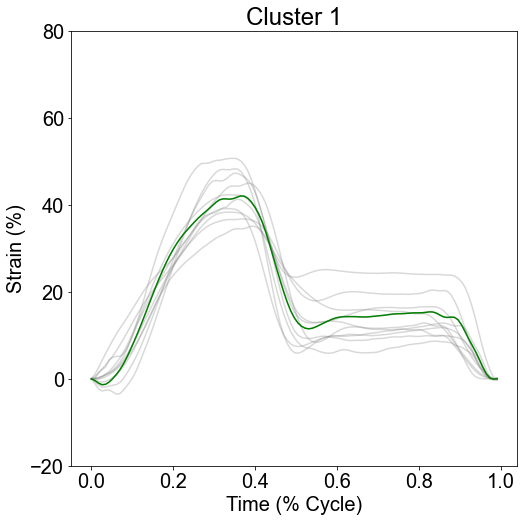

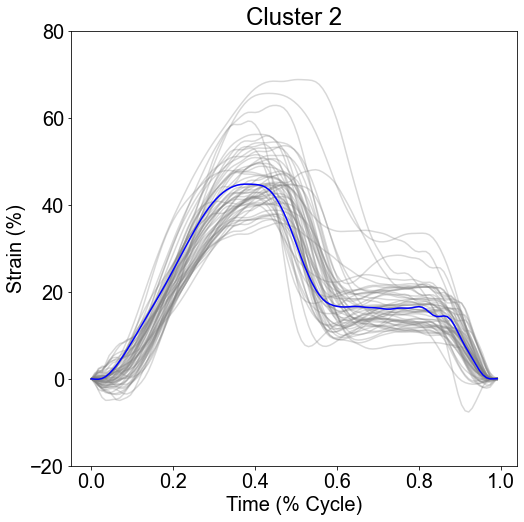

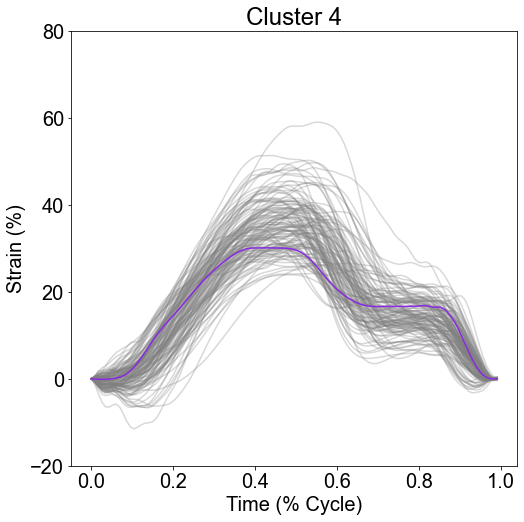

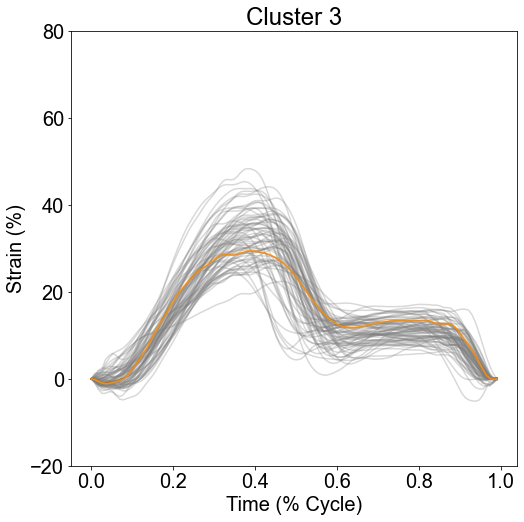

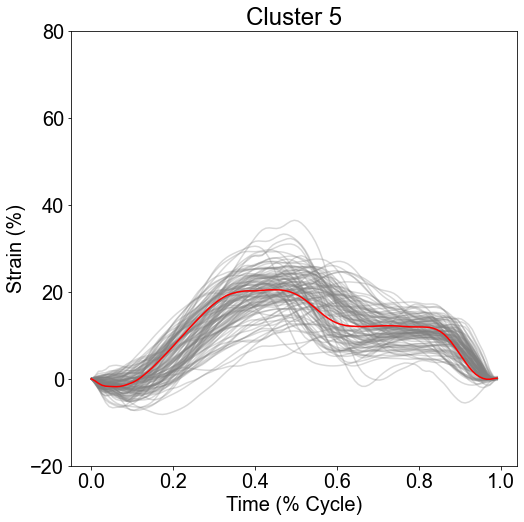

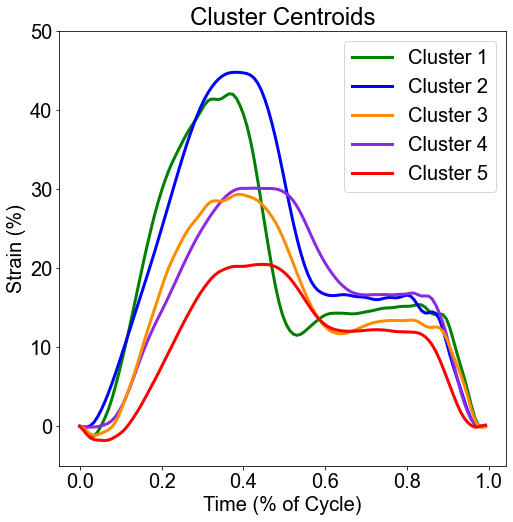

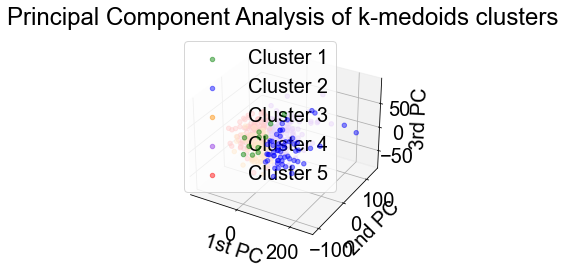

C:\Users\vagge\Desktop\Deformation Curves\VAE\utils.py:154: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\vagge\Desktop\Deformation Curves\VAE\utils.py:163: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

100%|██████████| 379/379 [01:43<00:00,  3.64it/s]


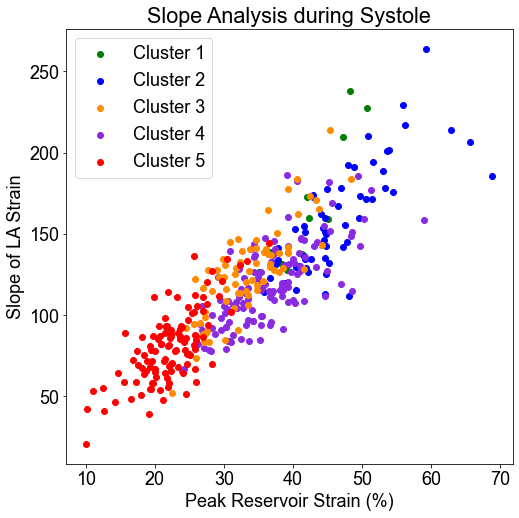

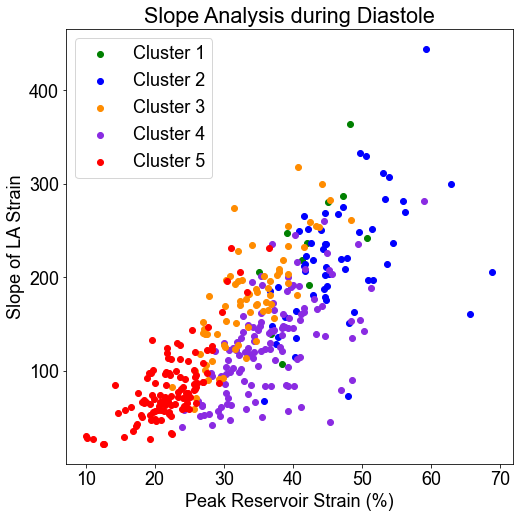

In [5]:
# load the trained CNN Autoencoder
autoencoder = keras.models.load_model(os.path.join(parent_folder, "Results/AE_k-medoids/AE Model"))

# get the clustering results using the latent space and the trained k-medoids algorithm
clusters, clustering_model, representative_centers = cluster_latent_dim(autoencoder, deformation)

# use the Autoencoder to reconstruct the strain curves
reconstruct_curves(autoencoder, deformation, patient_id, reference_time, save_data_path)

# get the ids of the participants per cluster
clustered_id = analyze_patient(clusters, patient_id)

# writes an excel file with the patient's ID and its assigned cluster label
write2excel(clusters, patient_id, save_data_path)

# plot the strain curves grouped in each cluster and the centroids of each cluster
visualize_clustering_results(reference_time, deformation, clustered_id, clusters, patient_id, representative_centers,
                             save_data_path)

# plot the first three principal components of the strain curves
plot_pca(clusters, deformation, patient_id, save_data_path)

# plots the gradient of the Strain traces with Matplotlib and plotly.
plot_gradients(deformation, reference_time, clusters, clustered_id, patient_id, save_data_path)

# calculate the slopes of the strain curves by fitting a linear Regression model
systolic, diastolic = calculate_slopes(deformation, reference_time, patient_id, save_data_path)

# plots the slopes of the Strain traces
plot_slopes(deformation, clusters, clustered_id, patient_id, systolic, diastolic, save_data_path)